In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
code = 'MSFT'
apple = yf.Ticker(code)
data =  apple.history(interval='1d',start='2018-01-01',end='2023-10-01')
df  = pd.DataFrame(data)
header = ['Open','High','Low','Close','Volume']
df = df[header]
df['Next_close'] = df['Close'].shift(-1)
df.dropna(inplace=True)
df.head()
df['Daily yield (%)'] = (df['Next_close'] / df['Close'] - 1)* 100
df.head()
#dat = df[['Open','High','Low','Close','Volume','Next_close']]
#dat.corr()

,Open,High,Low,Close,Volume,Next_close,Daily yield (%)
Date,,,,,,,
2018-01-02 00:00:00-05:00,80.397023,80.565042,79.808960,80.229004,22483800,80.602386,0.465396
2018-01-03 00:00:00-05:00,80.331689,80.751740,80.247683,80.602386,26061400,81.311813,0.880156
2018-01-04 00:00:00-05:00,80.826421,81.825207,80.807756,81.311813,21912000,82.319916,1.239798
2018-01-05 00:00:00-05:00,81.825195,82.525273,81.610501,82.319916,23407100,82.403915,0.102040
2018-01-08 00:00:00-05:00,82.329239,82.683950,81.769177,82.403915,22113000,82.347916,-0.067958


In [4]:
x_data = df[['Close','Volume','Daily yield (%)']]
y_data = df[['Next_close']]
x_train, x_test, y_train, y_test = x_data[:1345], x_data[1346:], y_data[:1345], y_data[1346:]

Text(0, 0.5, 'Stock Price')

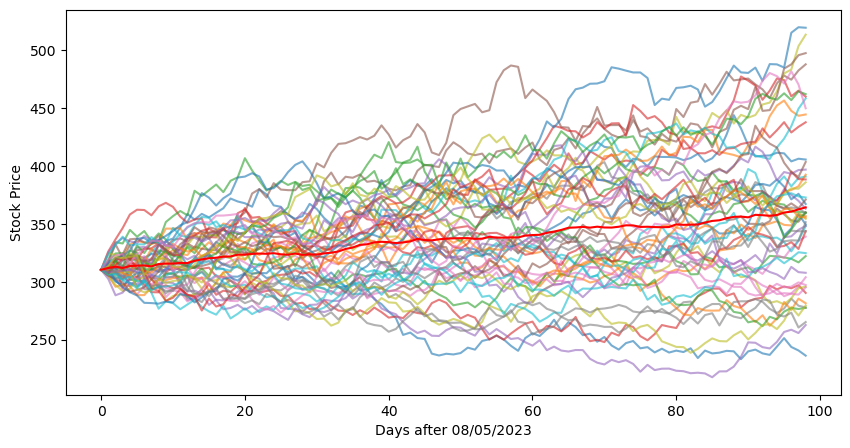

In [5]:
#Monte carlo
#Parametres: drift, mean, variance; nombre de simulation
Data_mean = np.log(1 + x_train['Daily yield (%)'].mean()/100)

Data_sq = (0.01*x_train['Daily yield (%)']).std()

drift = Data_mean - 0.5*Data_sq**2

n = 50

simulations = np.zeros((n,len(y_test)))
simulations[:,0] = y_test['Next_close'][0]

for i in range(1, len(y_test)):
    rendements = np.random.normal(Data_mean, Data_sq, n)
    simulations[:, i] = simulations[:,i - 1] * np.exp(rendements)
    
temps = np.arange(len(y_test))
plt.figure(figsize=(10, 5))
for i in range(n):
    plt.plot(temps,simulations[i, :], label=f'Scenario {i + 1}', alpha=0.6)

#plt.legend()
simulations_mean = np.zeros(len(y_test))
for i in range(len(y_test)):
    simulations_mean[i] = simulations[:,i].mean()
    
plt.plot(simulations_mean,'r')
plt.xlabel('Days after 08/05/2023')
plt.ylabel('Stock Price')

In [104]:
y_data.shape

(1445, 1)

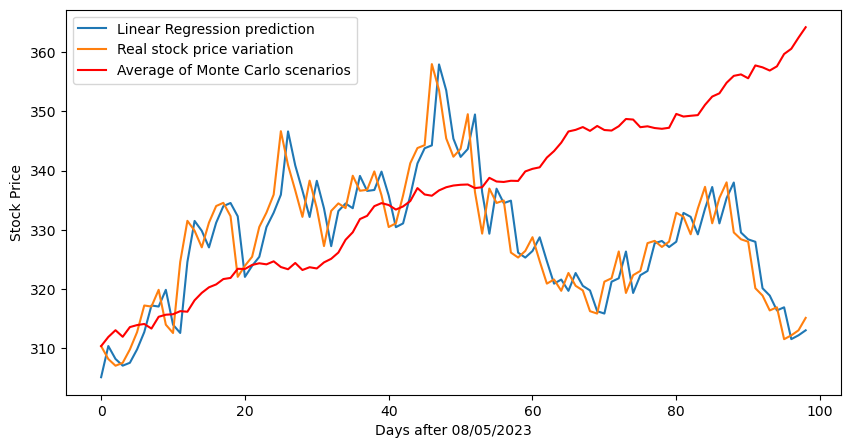

In [6]:
Lr = LinearRegression()
Lr.fit(x_train[['Close']],y_train)
Lr.score(x_train[['Close']],y_train[['Next_close']])
yhat = Lr.predict(x_test[['Close']])

plt.figure(figsize=(10, 5))

plt.plot(yhat,label='Linear Regression prediction')

plt.plot(temps,np.array(y_test['Next_close']), label='Real stock price variation')
plt.plot(simulations_mean,'r',label='Average of Monte Carlo scenarios')
plt.xlabel('Days after 08/05/2023')
plt.ylabel('Stock Price')
plt.legend()

In [7]:
print(f"Le MSE du Modèle brownien est: {mean_squared_error(simulations_mean,y_test['Next_close'])}")
print(f"Le MSE de la RL est: {mean_squared_error(yhat,y_test['Next_close'])}")

Le MSE du Modèle brownien est: 371.06045446254075
Le MSE de la RL est: 21.82782384417464


In [87]:
x_test 

,Close,Volume,Daily yield (%)
Date,,,
2023-05-09 00:00:00-04:00,305.063934,21340800,1.729644
2023-05-10 00:00:00-04:00,310.340454,30078000,-0.704429
2023-05-11 00:00:00-04:00,308.154327,31680200,-0.367602
2023-05-12 00:00:00-04:00,307.021545,19758100,0.158581
2023-05-15 00:00:00-04:00,307.508423,16336500,0.736778
...,...,...,...
2023-09-22 00:00:00-04:00,316.367889,21447900,0.167188
2023-09-25 00:00:00-04:00,316.896820,17836000,-1.700575
2023-09-26 00:00:00-04:00,311.507751,26297600,0.208239
